# 1. Import needed libraries and load competition data

In [187]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import os
from torch.utils.data import TensorDataset

In [188]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train = torch.from_numpy(np.load("/kaggle/input/solvrocompetition/X_train.npy")).to(torch.float)#.to(device)
X_test = torch.from_numpy(np.load("/kaggle/input/solvrocompetition/X_test.npy")).to(torch.float)#.to(device)
X_val = torch.from_numpy(np.load("/kaggle/input/solvrocompetition/X_val.npy")).to(torch.float)#.to(device)

y_train = torch.from_numpy(np.load("/kaggle/input/solvrocompetition/y_train.npy")).to(torch.float)#.to(device)
y_val = torch.from_numpy(np.load("/kaggle/input/solvrocompetition/y_val.npy")).to(torch.float)#.to(device)

## 1.1. Now I'm checking loaded data shape and how does my data look liketo know what I'm working with

In [189]:
y_train.shape, X_train.shape

(torch.Size([151166, 26]), torch.Size([151166, 28, 28]))

In [190]:
X_train[0].shape, X_val[0].shape, y_train[0].shape, y_val[0].shape

(torch.Size([28, 28]),
 torch.Size([28, 28]),
 torch.Size([26]),
 torch.Size([26]))

In [191]:
y_train[0], y_train[0].nonzero(), y_val[0].shape, X_val.shape

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0.]),
 tensor([[20]]),
 torch.Size([26]),
 torch.Size([37792, 28, 28]))

## 1.2. Converting my data into desired shape that will be useful later

In [192]:
y_train_labels = torch.argmax(y_train, dim=1).squeeze()
y_val_labels = torch.argmax(y_val, dim=1).squeeze()
# Print the converted tensor
# print(len(y_train_labels))
# print(len(y_train))
# print(len(y_val))
# print(len(y_val_labels))
print(y_train.shape)
print(y_train_labels.shape)
print(y_val.shape)
print(y_val_labels.shape)


torch.Size([151166, 26])
torch.Size([151166])
torch.Size([37792, 26])
torch.Size([37792])


# 2. Visualising my EMNIST Data

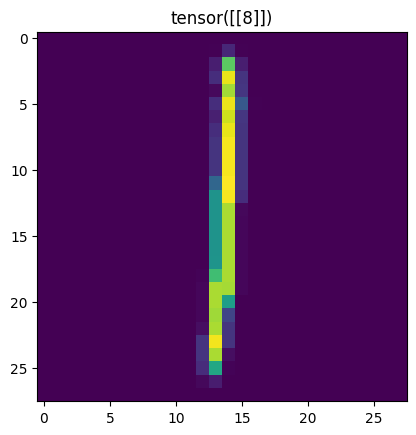

In [193]:
random_index = torch.randint(0, len(X_train), size=[1]).item()
face1 = X_train[random_index].to("cpu").reshape(28,28)
plt.imshow(face1)
plt.title(y_train[random_index].nonzero())
plt.show()

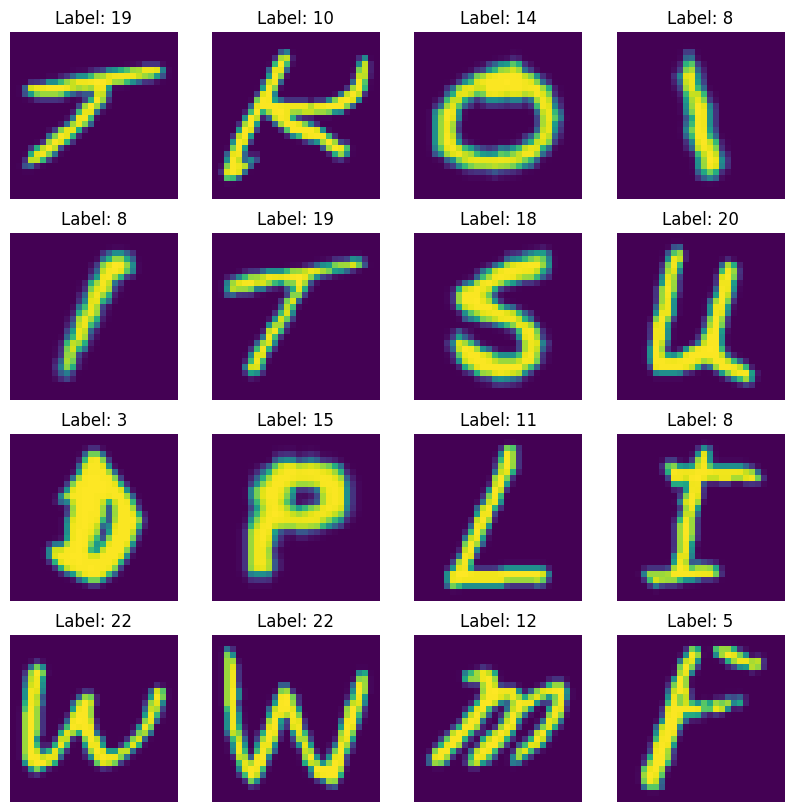

In [194]:
fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_index = torch.randint(0, len(X_train), size=[1]).item()
    face1 = X_train[random_index].to("cpu").reshape(28,28)
    fig.add_subplot(rows, cols, i)
    label = y_train[random_index]
    plt.imshow(face1)
    plt.title("Label: " + str(label.nonzero().item()))
    plt.axis(False);

# 3. Getting my data into datasets 

## 3.1. I'm checking what shape I'll need later for my data to have. 
I want to have [1, 28, 28]. First value are color channels (there's only one since it's black and white img) and two 28 representing pixels in width and height

In [195]:
X_train.unsqueeze(1)[0].shape
# X_val[0].shape

torch.Size([1, 28, 28])

## 3.2 Convert y_train into a tensor of classes. 
I want to change labels shape to have just a class name instead of vectors of zero's and one to get rid of shape issues later.

In [196]:
classes_tensor = torch.argmax(y_train)

classes_tensor, y_train

(tensor(20),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]]))

In [197]:
# Before I relised there is built-in pytorch method for creating dataset I created my own class ;(

print(X_val.unsqueeze(1).size())
print(y_val.size())
print(y_val_labels.size())


transform = transforms.Compose([
    transforms.ToPILImage(),  # since the input dtype is numpy.ndarray (H, W, C)
    transforms.RandomHorizontalFlip(),  # with 0.5 probability
    transforms.RandomVerticalFlip(),  # with 0.5 probability
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # normalise the image tensor with mean and standard deviation
])


# train_dataset = TensorDataset(X_train.unsqueeze(1), y_train_labels)
# val_dataset = TensorDataset(X_val.unsqueeze(1), y_val_labels)

# from torchvision.transforms import ToTensor
# from torchvision import datasets
# split = 'byclass'


# I used this data for my tests before, because I already knew it's properties so I knew how my model would look like
# train_dataset = datasets.EMNIST(
#     root="data",
#     split=split,  # Specify the split here
#     train=True,
#     download=True,
#     transform=ToTensor(),
#     target_transform=None
# )

# val_dataset = datasets.EMNIST(
#     root="data",
#     split=split,  # Specify the split here
#     train=False,
#     download=True,
#     transform=ToTensor()
# )


class TransformedDataset(Dataset):
    def __init__(self, data, target, transform=None, target_transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = self.transform(x)
        
        y = self.target[index]
        if self.target_transform:
            y = self.target_transform(y)
            
        return x, y
train_dataset = TransformedDataset(X_train.unsqueeze(1), y_train_labels, transform)
val_dataset = TransformedDataset(X_val.unsqueeze(1), y_val_labels, transform)
# test_dataset = CustomDataset(X_test, y_test)


print(len(train_dataset))
print(len(val_dataset))
# print(y_val_labels.size())

torch.Size([37792, 1, 28, 28])
torch.Size([37792, 26])
torch.Size([37792])
151166
37792


In [198]:
labels = torch.unique(y_val_labels)

In [199]:
# Get the first sample and its label from the dataset
sample, label = train_dataset[0]

# Print the shape of the sample and the label
print("Sample shape:", sample.shape)
print("Label shape:", label.shape)
print(label)

Sample shape: torch.Size([1, 28, 28])
Label shape: torch.Size([])
tensor(20)


# 4. Creating data loaders.

They're usefull if we don't want to overload memory, or manipulate data (f.e. augmentation)

In [200]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Długość treningowego dataloadera: {len(train_dataloader)} | wielkość batcha: {BATCH_SIZE}")
print(f"Długość walidacyjnego dataloadera: {len(val_dataloader)} | wielkość batcha: {BATCH_SIZE}")

Długość treningowego dataloadera: 4724 | wielkość batcha: 32
Długość walidacyjnego dataloadera: 1181 | wielkość batcha: 32


In [201]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# 5. Defining my model

In [202]:
class_names_amount = len(y_train[0])
# print(class_names_amount)
class EMNIST_Model(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
      super().__init__()
      self.block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, 
                    stride=1, 
                    padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
      )
      self.block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=hidden_units*7*7,
                    out_features=output_shape)
      )

  def forward(self, x):
    return self.classifier(self.block_2(self.block_1(x)))

model = EMNIST_Model(1, 10, class_names_amount).to(device)
model

EMNIST_Model(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=26, bias=True)
  )
)

In [203]:
# next(iter(val_dataloader)).shape, next(iter(train_dataloader)).shape,X_test.unsqueeze(1).shape

# 6. Defining my helping functions for training and training functions themselves 

In [204]:
# My custom accuracy function
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> [torch.float]:
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.03)

EPOCHS = 4

In [205]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device = device):
  train_loss, train_acc = 0, 0
  model.train()
  model.to(device)
  for batch, (X,y) in enumerate(dataloader):
    #print(X.shape)
    X, y= X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [206]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.float().to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)
      )

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [207]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          epochs: int,
          device:torch.device = device):

  from timeit import default_timer as timer
  from tqdm.auto import tqdm
  train_time_start = timer()

  for epoch in tqdm(range(epochs)):
    if epoch % 200:
      print(f"Epochs: {epoch}\n-----------------------")

    train_step(model=model,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    test_step(model=model,
              dataloader=val_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

  train_time_end = timer()
  print(f"{(train_time_end - train_time_start):.3f}")

In [126]:
train(model=model,
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      epochs=EPOCHS)

  0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.24644 | Train accuracy: 62.77%
Test loss: 0.74684 | Test accuracy: 77.34%

Epochs: 1
-----------------------
Train loss: 0.63007 | Train accuracy: 80.91%
Test loss: 0.55164 | Test accuracy: 83.55%

Epochs: 2
-----------------------
Train loss: 0.58033 | Train accuracy: 82.52%
Test loss: 0.54606 | Test accuracy: 83.42%

Epochs: 3
-----------------------
Train loss: 0.49547 | Train accuracy: 84.95%
Test loss: 0.47114 | Test accuracy: 85.96%

295.007


In [174]:
from pprint import pprint 
print(device)
# print("Wartosci, którch nauczył się model:")
# pprint(model.state_dict()[])

cuda


# 7. Making predictions and visualising them

In [208]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            print(sample.device)

            print(data[0].device)
            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)


In [209]:
import random
#random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(val_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"wymiary przykładowej litery: {test_samples[0].shape}\nEtykieta dla przykładu: {test_labels[0]} ({labels[test_labels[0]]})")

wymiary przykładowej litery: torch.Size([1, 28, 28])
Etykieta dla przykładu: 11 (11)


In [210]:
pred_probs= make_predictions(model=model,
                             data=test_samples)

pred_probs[:2]

cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu


tensor([[0.0361, 0.0387, 0.0404, 0.0388, 0.0391, 0.0377, 0.0382, 0.0416, 0.0379,
         0.0405, 0.0434, 0.0402, 0.0375, 0.0390, 0.0369, 0.0371, 0.0357, 0.0382,
         0.0379, 0.0374, 0.0417, 0.0343, 0.0408, 0.0388, 0.0375, 0.0348],
        [0.0359, 0.0388, 0.0399, 0.0387, 0.0393, 0.0376, 0.0381, 0.0420, 0.0381,
         0.0406, 0.0436, 0.0403, 0.0376, 0.0391, 0.0370, 0.0373, 0.0357, 0.0382,
         0.0379, 0.0371, 0.0419, 0.0341, 0.0408, 0.0385, 0.0369, 0.0348]])

In [211]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([10, 10, 10, 10, 10, 10, 10, 10, 10])

In [212]:
test_labels, pred_classes

([tensor(11),
  tensor(17),
  tensor(14),
  tensor(10),
  tensor(14),
  tensor(20),
  tensor(8),
  tensor(18),
  tensor(18)],
 tensor([10, 10, 10, 10, 10, 10, 10, 10, 10]))

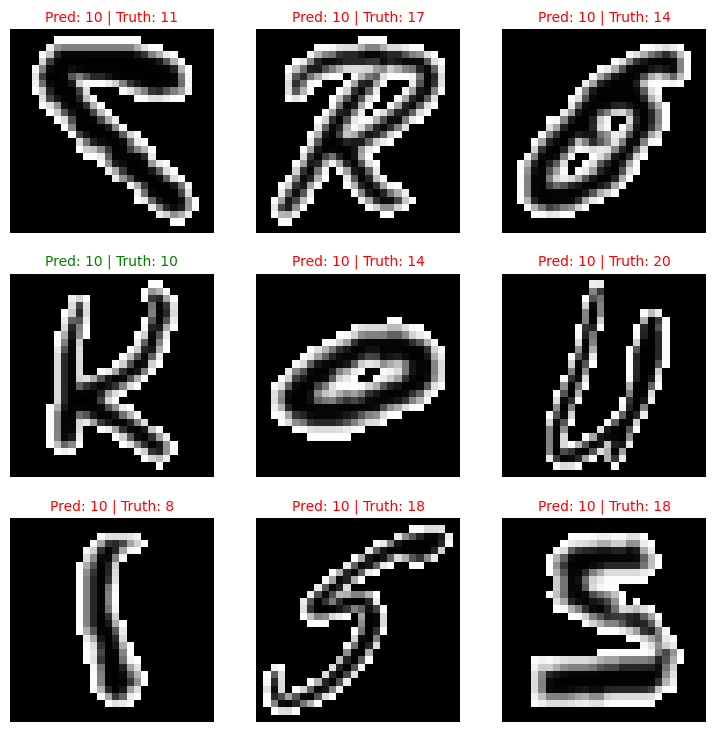

In [213]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):

  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = labels[pred_classes[i]]

  truth_label = labels[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

# 8. Saving and loading my model

In [214]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "SOLVRO_EMNIST_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Zapisano model w: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Zapisano model w: models/SOLVRO_EMNIST_model.pth


In [215]:
loaded_model = EMNIST_Model(1, 10, len(labels))

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

# 9. Making predictions with my model

In [216]:
print(X_test.shape)
# X_test = X_test.permute(1, 2, 0)
X_test = X_test.unsqueeze(1).to(device)
print(X_test.shape)

torch.Size([31346, 28, 28])
torch.Size([31346, 1, 28, 28])


In [217]:
model.eval()

with torch.inference_mode():
    model_preds = model(X_test)

In [219]:

# loaded_model.eval()

# with torch.inference_mode():
#     loaded_model_preds = loaded_model(X_test) 

In [220]:
# zamieniam predykcje na np array a potem na df a potem daję do pliku csv
results = model_preds.argmax(dim=1).cpu().numpy()

sample_submission = pd.DataFrame(results, columns=['class'])
sample_submission.index.name = "index"

sample_submission.to_csv('sample_submission.csv')